In [27]:
import matplotlib.pyplot as plt
import numpy as np
import os
from posterior_inference import *
from scipy.interpolate import interp1d
from tqdm import tqdm

# $M_{\mathrm{PBH}} = 0.5 ~ M_\odot$ + LIGO 03

## Compute $p_\gamma$ over a $(\langle \sigma v \rangle, m_{\mathrm{DM}})$ grid for fixed $M_{\mathrm{PBH}}$

While the range of $\langle \sigma v\rangle$ values below is good for this set of DM and PBH masses, it will likely need to be tuned for other ones. An interpolator for the resulting data file can be loaded with
```python
load_p_gamma(m_pbh)
```

In [1]:
m_pbh = 0.5
m_dms = np.logspace(1, 4, 200)
sv_pts = np.logspace(-43, -29, 200)

m_dm_col = np.repeat(m_dms, sv_pts.size)
sv_col = np.tile(sv_pts, m_dms.size)

p_gammas = []
for m_dm in tqdm(m_dms):
    p_gammas.append(get_p_gamma_val(m_pbh, m_dm, sv_pts))
p_gammas = np.array(p_gammas).flatten()

np.savetxt("data/p_gamma_M=%.1f.csv" % m_pbh, np.array([m_dm_col, sv_col, p_gammas]).T,
           header=("p_gamma for M_PBH = %.1f M_sun.\n"
                   "Columns are: m_DM (GeV), <sigma v> (cm^3/s), p_gamma.") % m_pbh)

NameError: name 'np' is not defined

## $p(\langle \sigma v \rangle | N_{\mathrm{PBH}}, N_U)$

In [2]:
m_pbh = 0.5  # PBH mass, M_sun
n_pbh = 1  # number of detected PBHs

# Loads p(f|N_PBH) for GW experiments, computed by Bradley.
# The third argument specifies the directory containing the
# posterior data files.
p_f = load_p_f_gw(m_pbh, n_pbh)

# Loads p_gamma(m_DM, <sigma v>) for the specified PBH mass.
svs, m_dms, p_gamma = load_p_gamma(m_pbh)

In [ ]:
# Evaluate posterior over a grid of <sigma v> and m_DM values
sv_mg, m_dm_mg = np.meshgrid(svs, m_dms)

# This array satisfies
#    post_vals[i, j] = p(svs[j] | m_dms[i]).
post_vals = get_posterior_val(sv_mg, n_pbh, n_u_0, p_f, p_gamma, m_pbh, m_dm_mg)

(1e-43, 1e-29)

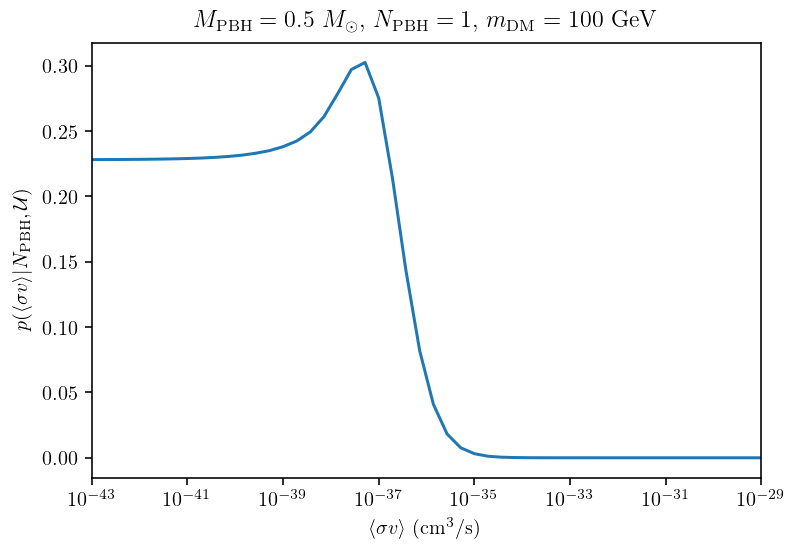

In [5]:
# Plot results for lowest DM mass
plt.plot(svs, post_vals[0])

plt.xscale("log")
plt.xlabel(r"$\langle \sigma v \rangle$ (cm$^3$/s)")
plt.ylabel(r"$p(\langle \sigma v \rangle | N_{\mathrm{PBH}}, \mathcal{U})$")
plt.title((r"$M_{\mathrm{PBH}} = %.1f~M_\odot$, $N_{\mathrm{PBH}} = 1$, "
           r"$m_{\mathrm{DM}} = %i$ GeV") % (m_pbh, m_dm[0]), fontsize=12)
plt.xlim(svs[[0, -1]])

In [8]:
os.system("say 'Did it!'")

0

# Developing script for the cluster

Should make two parts of the script:
* One to generate the `p_gamma` tables. This should take `m_pbh` as a command line argument and create a file in the `data/` directory. Optional arguments:
    * `n_samples`: number of MC samples
    * `m_dm_min`, `m_dm_max`, `n_m_dms`: parameters controlling range and number of DM masses
    * `sv_min`, `sv_max`, `n_svs`: parameters controlling range and number of cross sections
* Another to generate tables of the posterior for $\langle \sigma v \rangle$ given `m_pbh` and `n_pbh`. This should take `m_pbh` and `n_pbh` as arguments. The posterior will be computed at the values of `m_dm` and `sv` from the relevant `p_gamma` table.

## Finding a good range for `sv`

Make sure `sv` range works for `m_pbh` between 0.2 and 1, as well as 10.
* `np.log10(svs) = -45, ..., -25`

This cell loads the $p_\gamma$ table if it exists, or creates and loads it if it doesn't.

In [22]:
m_pbh = 0.2
n_pbh = 10  # number of detected PBHs

print("Creating p_gamma table")
m_dms = np.logspace(1, 4, 2)
svs = np.logspace(-45, -25, 10)
save_p_gamma_table(m_pbh, m_dms, svs, n_samples=100000)
m_dms, svs, p_gamma = load_p_gamma(m_pbh)
print("Loaded p_gamma table")

Creating p_gamma table
Loaded p_gamma table


This cell loads $p(f|N_{\mathrm{PBH}})$

In [23]:
# Loads p(f|N_PBH) for GW experiments, computed by Bradley.
# The third argument specifies the directory containing the
# posterior data files.
p_f = load_p_f_gw(m_pbh, n_pbh)

In [24]:
save_posterior_table(svs, n_pbh, p_f, p_gamma, m_pbh, m_dms)

In [25]:
m_dms, svs, post_vals = load_posterior(m_pbh, n_pbh)

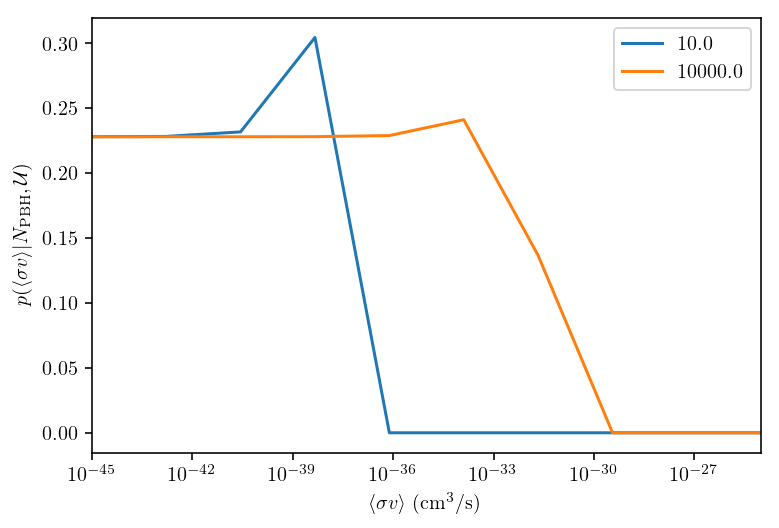

In [26]:
# Plot results for lowest DM mass
plt.plot(svs, post_vals[0], label=m_dms[0])
plt.plot(svs, post_vals[-1], label=m_dms[-1])

plt.xscale("log")
plt.xlabel(r"$\langle \sigma v \rangle$ (cm$^3$/s)")
plt.ylabel(r"$p(\langle \sigma v \rangle | N_{\mathrm{PBH}}, \mathcal{U})$")
# plt.title((r"$M_{\mathrm{PBH}} = %.1f~M_\odot$, $N_{\mathrm{PBH}} = 1$, "
#            r"$m_{\mathrm{DM}} = %i$ GeV") % (m_pbh, m_dms[0]), fontsize=12)
plt.xlim(svs[[0, -1]])
plt.legend()

In [17]:
os.system("say 'Done'")

0

In [28]:
# Evaluate posterior over a grid of <sigma v> and m_DM values
sv_mg, m_dm_mg = np.meshgrid(svs, m_dms)

# This array satisfies
#    post_vals[i, j] = p(m_dms[i], svs[j]).
post_vals = get_posterior_val(sv_mg, n_pbh, n_u_0, p_f, p_gamma, m_pbh, m_dm_mg)

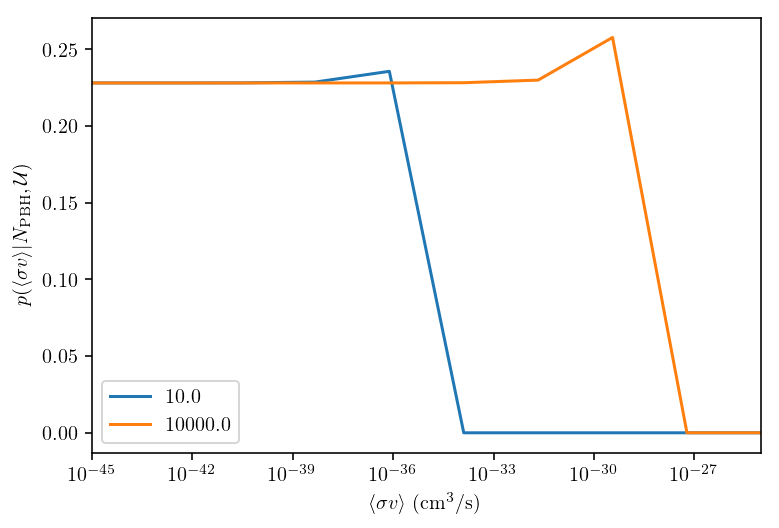

In [29]:
# Plot results for lowest DM mass
plt.plot(svs, post_vals[0], label=m_dms[0])
plt.plot(svs, post_vals[-1], label=m_dms[-1])

plt.xscale("log")
plt.xlabel(r"$\langle \sigma v \rangle$ (cm$^3$/s)")
plt.ylabel(r"$p(\langle \sigma v \rangle | N_{\mathrm{PBH}}, \mathcal{U})$")
plt.xlim(svs[[0, -1]])
plt.legend()

In [30]:
os.system("say 'Done'")

0

## Loading results generated by the script

In [29]:
m_pbh = 0.7
n_pbh = 1  # number of detected PBHs

m_dms, svs, post_vals = load_posterior(m_pbh, n_pbh)

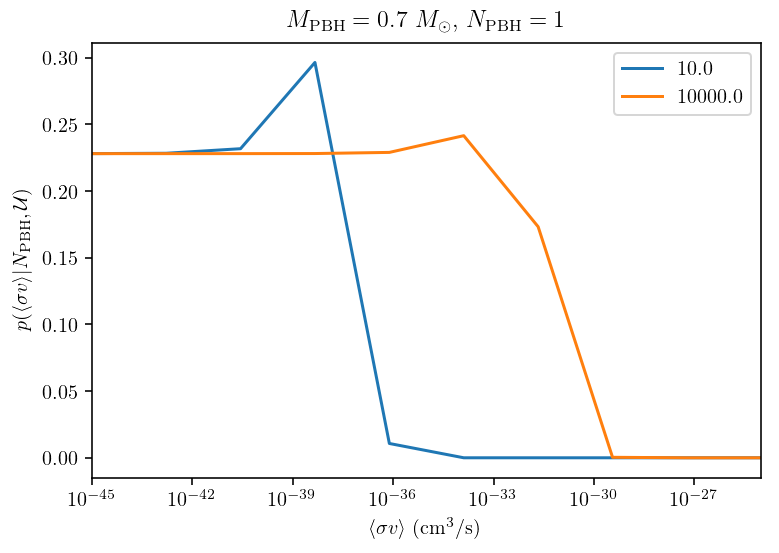

In [31]:
# Plot results for lowest DM mass
plt.plot(svs, post_vals[0], label=m_dms[0])
plt.plot(svs, post_vals[-1], label=m_dms[-1])

plt.xscale("log")
plt.xlabel(r"$\langle \sigma v \rangle$ (cm$^3$/s)")
plt.ylabel(r"$p(\langle \sigma v \rangle | N_{\mathrm{PBH}}, \mathcal{U})$")
plt.title(r"$M_{\mathrm{PBH}} = %.1f~M_\odot$, $N_{\mathrm{PBH}} = %i$" % (m_pbh, n_pbh), fontsize=12)
plt.xlim(svs[[0, -1]])
plt.legend()

# Scratch/development

In [96]:
m_dm_col, sv_col, p_gamma_col = np.loadtxt("data/p_gamma_M=%.1f.csv" % m_pbh).T

p_gammas[i, j] = p_gamma(m_dm[i], sv[j])

In [140]:
m_dms = np.unique(m_dm_col)
svs = np.unique(sv_col)
# m_dm_mg, sv_mg = np.meshgrid(m_dms, svs, indexing="ij", sparse=True)
p_gammas = p_gamma_col.reshape([m_dms.size, svs.size])

In [141]:
def load_p_gamma(m_pbh):
    m_dm_col, sv_col, p_gamma_col = np.loadtxt("data/p_gamma_M=%.1f.csv" % m_pbh).T
    m_dms = np.unique(m_dm_col)
    svs = np.unique(sv_col)
    p_gammas = p_gamma_col.reshape([m_dms.size, svs.size])
    p_gamma_rg = RegularGridInterpolator((m_dms, svs), p_gammas)

    def p_gamma(m_dm, sv):
        # Wrap the interpolator, since its interface is horrible
        m_dm = np.asarray(m_dm)
        sv = np.asarray(sv)

        if m_dm.size > 1 and sv.size > 1:
            return p_gamma_rg(np.array([m_dm, sv]).T)
        elif m_dm.size > 1:
            return p_gamma_rg(np.array([m_dm, sv*np.ones_like(m_dm)]).T)
        elif sv.size > 1:
            return p_gamma_rg(np.array([m_dm*np.ones_like(sv), sv]).T)
        else:
            return p_gamma_rg(np.array([m_dm, sv]))

    return p_gamma

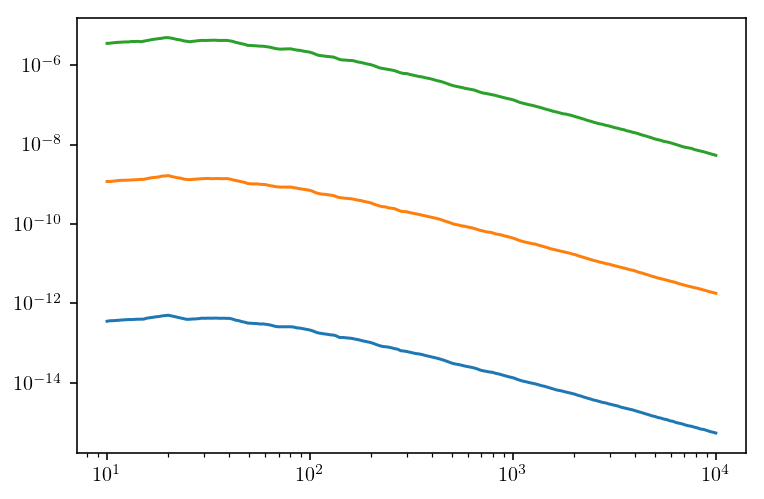

In [149]:
plt.plot(m_dms, p_gamma(m_dms, svs[0]))
plt.plot(m_dms, p_gamma(m_dms, svs[100]))
plt.plot(m_dms, p_gamma(m_dms, svs[-1]))
plt.xscale("log")
plt.yscale("log")

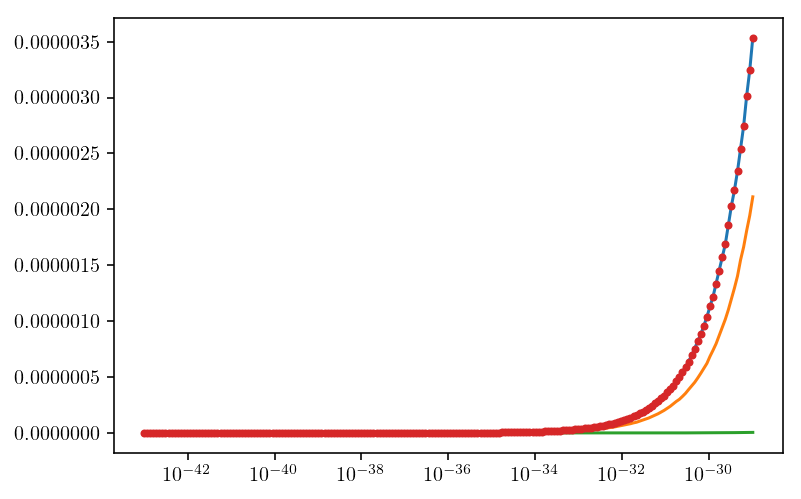

In [145]:
plt.plot(svs, p_gamma(1e1, svs))
plt.plot(svs, p_gamma(1e2, svs))
plt.plot(svs, p_gamma(1e4, svs))
plt.plot(svs, p_gamma_col[:svs.size], '.')
plt.xscale("log")

In [27]:
sv_pts = np.logspace(-43, -29, 100)
p_gamma_pts = get_p_gamma_val(m_pbh, m_dm, sv_pts)
p_gamma = interp1d(sv_pts, p_gamma_pts)

In [24]:
svs = np.logspace(-39, -26, 20)
posterior_vals = []

for sv in svs:
    posterior_vals.append(0)
    for n_gamma in np.arange(0, n_u_0+1, 1):
        posterior_vals[-1] += quad(lambda f: posterior_integrand(sv, n_gamma, f, n_pbh, n_u_0,
                                                                 p_f, p_gamma, m_pbh),
                                   1e-6, 1, epsabs=1e-99)[0]

posterior_vals = np.array(posterior_vals)

/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  if __name__ == '__main__':
/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:9: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  if __name__ == '__main__':
/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:9: IntegrationWarning: The algorithm does not conver

(1e-39, 1e-26)

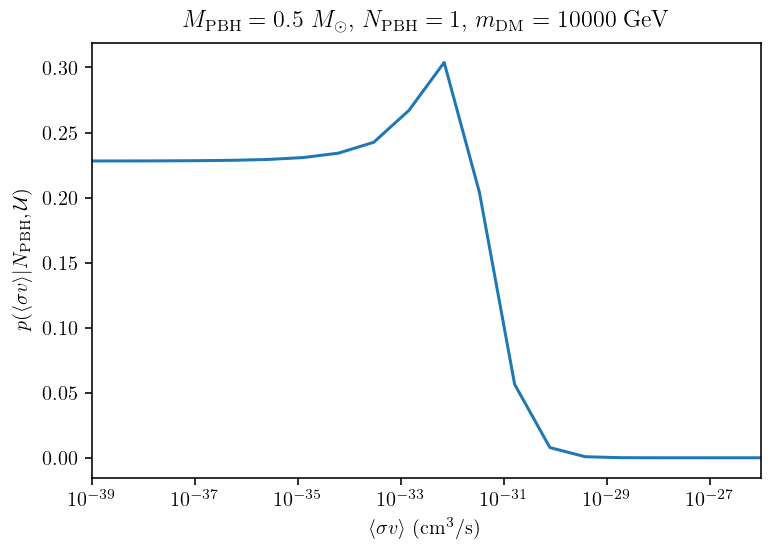

In [25]:
plt.plot(svs, posterior_vals)

plt.xscale("log")
plt.xlabel(r"$\langle \sigma v \rangle$ (cm$^3$/s)")
plt.ylabel(r"$p(\langle \sigma v \rangle | N_{\mathrm{PBH}}, \mathcal{U})$")
plt.title((r"$M_{\mathrm{PBH}} = %.1f~M_\odot$, $N_{\mathrm{PBH}} = 1$, "
           r"$m_{\mathrm{DM}} = %i$ GeV") % (m_pbh, m_dm), fontsize=12)
plt.xlim(svs[[0, -1]])

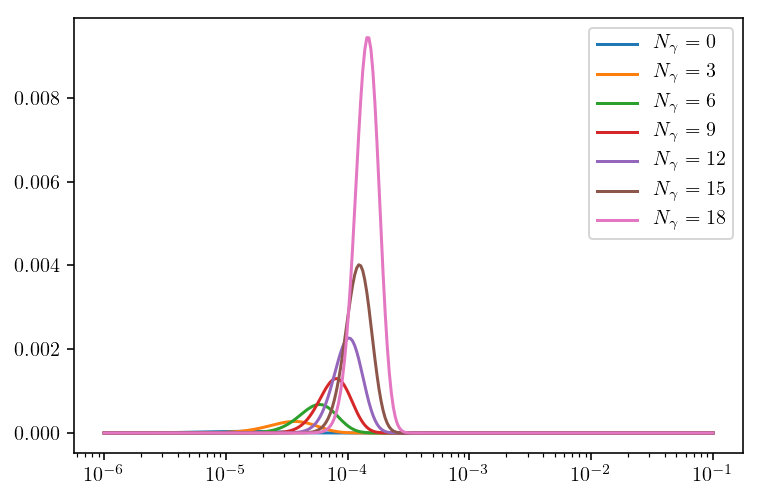

In [58]:
fs = np.logspace(-6, -1, 300)

for n_gamma in np.arange(0, 19, 3):
    plt.plot(fs, posterior_integrand(1e-33, n_gamma, fs, n_pbh, n_u_0, p_f, p_gamma, m_pbh),
             label=r"$N_\gamma=%i$" % n_gamma)

plt.xscale("log")
plt.legend()